# 06 - Computer Vision

This notebook continues the deep learning journey from **03** and shifts focus to **computer vision**.

## What you’ll learn
- How to think of an image as a **digital signal** (a tensor with structure).
- The main **computer vision problem types** (classification/detection/segmentation/etc.).
- Why **CNNs** dominated vision for years: **locality**, **weight sharing**, **feature maps**.
- A practical demonstration on **CIFAR-10**: why an **MLP** struggles and a **CNN** works better.


---
**Note:** We intentionally leave **Vision Transformers** for the next notebook.

## 0. Setup & Imports
We’ll keep the same "explicit training loop" style as notebook 03 for clarity.

In [1]:
from __future__ import annotations

import math
import os
import random
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, transforms

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

SEED = 42

def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

## 1. Images as Digital Signals
A color image is typically a **3D tensor**: `(C, H, W)` (channels-first in PyTorch).

- **Sampling:** the world is continuous; an image is a sampled grid.
- **Quantization:** pixel values are stored with finite precision (e.g., 8-bit 0–255).
- **Channels:** RGB are three related signals.

![](./assets/digital_image.png)

Let's start by loading a simple image and understanding how it is represented in the memory.

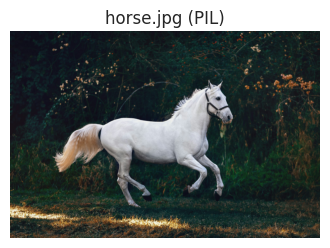

Tensor shape (C,H,W): (3, 500, 750)
dtype: torch.uint8
min/max: 1 255
per-channel mean (u8): [48.10770034790039, 56.23384475708008, 53.14338302612305]
per-channel std  (u8): [57.71845245361328, 51.219024658203125, 50.945892333984375]


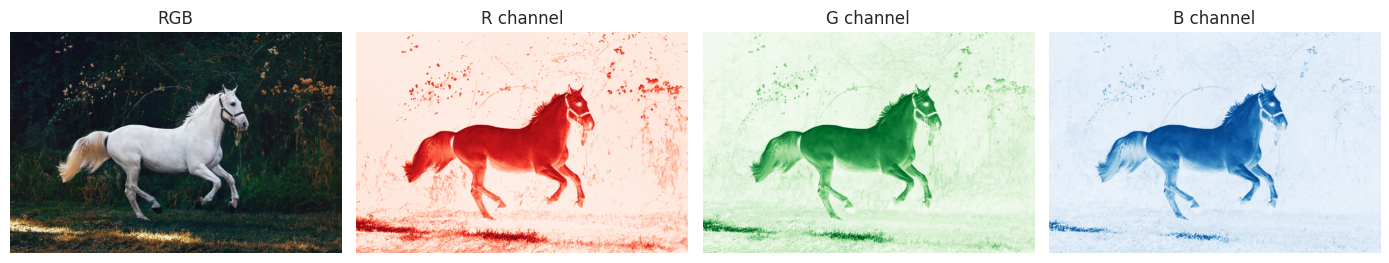

In [2]:
# Example: load a local image and analyze it as a tensor
# File is in: notebooks/assets/horse.jpg

horse_path = Path('assets') / 'horse.jpg'
assert horse_path.exists(), f"Missing file: {horse_path.resolve()}"

horse_pil = Image.open(horse_path).convert('RGB').resize((750, 500))

plt.figure(figsize=(4, 4))
plt.imshow(horse_pil)
plt.title('horse.jpg (PIL)')
plt.axis('off')
plt.show()

# Convert to tensor (C,H,W)
# - pil_to_tensor keeps uint8 (0..255) which is great for demonstrating quantization
# - to_tensor converts to float32 (0..1)
horse_u8 = TF.pil_to_tensor(horse_pil)  # uint8, shape (3,H,W)
horse_f = horse_u8.float() / 255.0

print('Tensor shape (C,H,W):', tuple(horse_u8.shape))
print('dtype:', horse_u8.dtype)
print('min/max:', int(horse_u8.min()), int(horse_u8.max()))
print('per-channel mean (u8):', [float(horse_u8[c].float().mean()) for c in range(3)])
print('per-channel std  (u8):', [float(horse_u8[c].float().std()) for c in range(3)])

# Split into R/G/B channels
r, g, b = horse_u8[0], horse_u8[1], horse_u8[2]

fig, axes = plt.subplots(1, 4, figsize=(14, 3))
axes[0].imshow(horse_u8.permute(1, 2, 0))
axes[0].set_title('RGB')
axes[0].axis('off')

axes[1].imshow(r, cmap='Reds')
axes[1].set_title('R channel')
axes[1].axis('off')

axes[2].imshow(g, cmap='Greens')
axes[2].set_title('G channel')
axes[2].axis('off')

axes[3].imshow(b, cmap='Blues')
axes[3].set_title('B channel')
axes[3].axis('off')

plt.tight_layout()
plt.show()


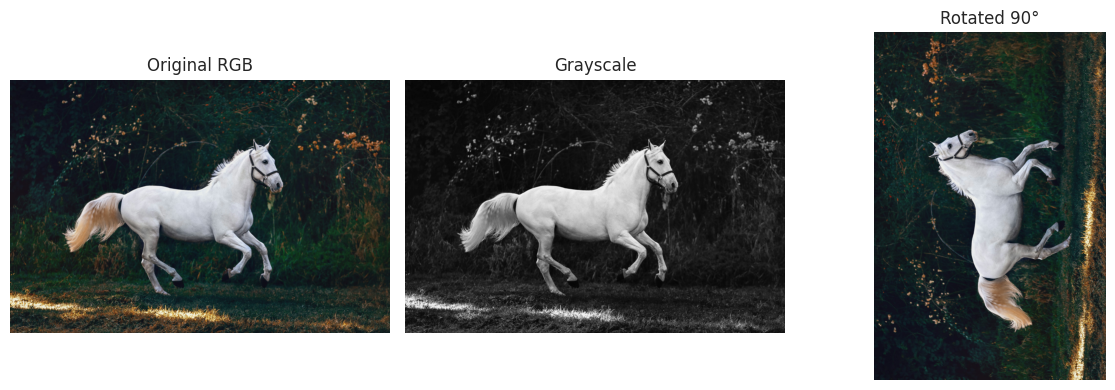

In [3]:
# Simple transformations
horse_gray_u8 = TF.rgb_to_grayscale(horse_u8, num_output_channels=1)  # (1,H,W)
horse_rot90_u8 = torch.rot90(horse_u8, k=1, dims=(1, 2))  # rotate 90 degrees

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(horse_u8.permute(1, 2, 0))
axes[0].set_title('Original RGB')
axes[0].axis('off')

axes[1].imshow(horse_gray_u8.squeeze(0), cmap='gray')
axes[1].set_title('Grayscale')
axes[1].axis('off')

axes[2].imshow(horse_rot90_u8.permute(1, 2, 0))
axes[2].set_title('Rotated 90°')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [4]:
horse_gray_u8.shape

torch.Size([1, 500, 750])

#### CIFAR 10 dataset
In notebook 03-deep-learning.ipynb we used MNIST dataset with digits images. At the time it was great for what we needed but since we plan to learn about CNNs, we now need a more challenging dataset. CIFAR10 is a collection of 32x32 RGB images representing different objects in the real world (10 classes). 

Let's now download CIFAR10 dataset we will be working with later and investigate it as a tensor of pixel values.

In [5]:
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

# For signal inspection we start with raw ToTensor() (values in [0, 1]).
transform_raw = transforms.ToTensor()

train_raw = datasets.CIFAR10(root=str(DATA_DIR), train=True, download=True, transform=transform_raw)
test_raw = datasets.CIFAR10(root=str(DATA_DIR), train=False, download=True, transform=transform_raw)

classes = train_raw.classes
len(train_raw), len(test_raw), classes

(50000,
 10000,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

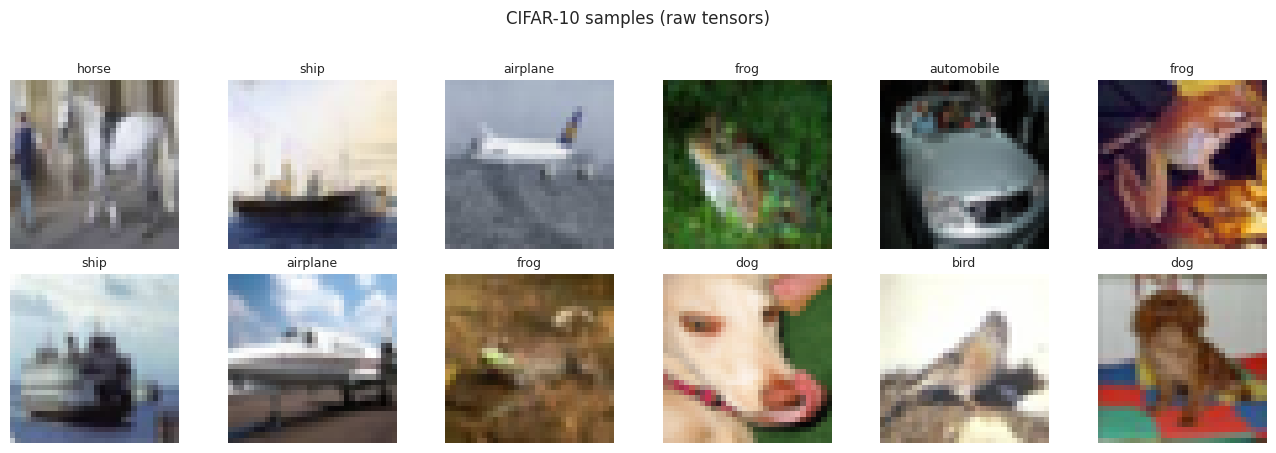

In [6]:
def show_images(dataset: Dataset, n: int = 12, title: str | None = None) -> None:
    idxs = np.random.choice(len(dataset), size=n, replace=False)
    cols = 6
    rows = int(math.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    axes = np.array(axes).reshape(-1)

    for ax, idx in zip(axes, idxs):
        x, y = dataset[idx]
        ax.imshow(x.permute(1, 2, 0))
        ax.set_title(classes[y], fontsize=9)
        ax.axis('off')

    for ax in axes[len(idxs):]:
        ax.axis('off')

    if title:
        fig.suptitle(title, y=1.02)
    plt.tight_layout()

show_images(train_raw, n=12, title='CIFAR-10 samples (raw tensors)')

In [7]:
x0, y0 = train_raw[0]
print('Shape (C,H,W):', tuple(x0.shape))
print('dtype:', x0.dtype)
print('min/max:', float(x0.min()), float(x0.max()))
print('label:', y0, '-', classes[y0])

# Channel-wise stats for one image
print('per-channel mean:', [float(x0[c].mean()) for c in range(3)])
print('per-channel std :', [float(x0[c].std()) for c in range(3)])

Shape (C,H,W): (3, 32, 32)
dtype: torch.float32
min/max: 0.0 1.0
label: 6 - frog
per-channel mean: [0.5537453889846802, 0.4121553301811218, 0.25112593173980713]
per-channel std : [0.15954329073429108, 0.16647100448608398, 0.16026239097118378]


## 2. What is Computer Vision? (Problem Types + Short History)
Computer vision is about extracting meaning from images/video.

### Common problem types
- **Classification:** what is in the image? (one label)
- **Detection:** what objects and where? (boxes + labels)
- **Segmentation:** label every pixel (masks)
- **Keypoints / Pose:** locate landmarks (hands, joints, face)
- **Tracking:** follow objects over time
- **Generation:** create images (diffusion/GANs)

![](./assets/cv_problems.png)

### Short history (very compressed)
1. **Handcrafted features** (edges, corners, SIFT/HOG) + shallow ML
2. **Deep learning** begins to dominate (2012–): CNNs learn features from data
3. CNN backbones become standard building blocks for many CV tasks

## 3. CNNs: Why They Work So Well
An MLP can *technically* learn from images, but it throws away the **2D structure** by flattening.
CNNs keep spatial structure and build features hierarchically.

### Core ideas
- **Locality:** nearby pixels are related (edges, textures).
- **Weight sharing:** the same kernel is used across the whole image.
- **Translation equivariance:** shifting the input shifts feature maps (approximately).
- **Feature maps:** each conv layer produces multiple channels of learned filters.


### A tiny bit of "signal processing"
Edge detection is one of the classic ideas in computer vision.
Let’s apply a simple Sobel-like filter to a single image (in grayscale) using `conv2d`.

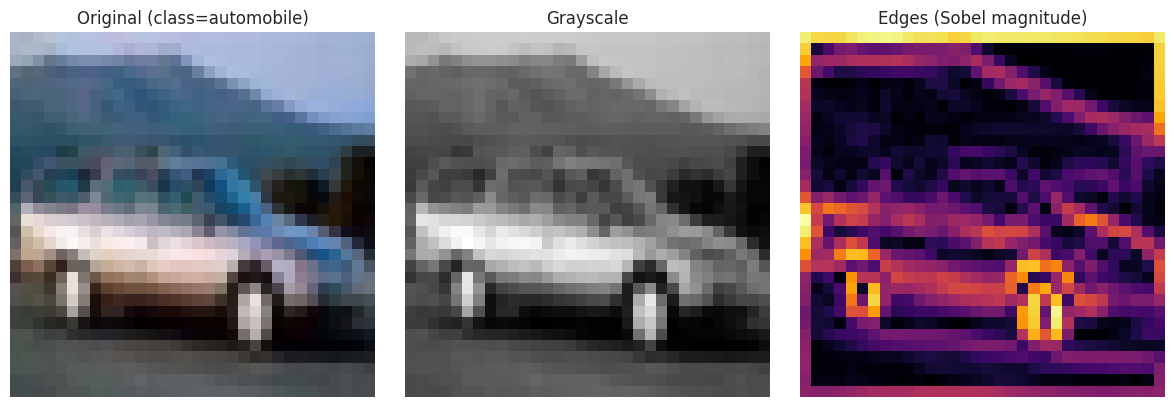

In [8]:
# Pick one image
img, label = train_raw[4]
img_gray = img.mean(dim=0, keepdim=True)  # (1,H,W)

sobel_x = torch.tensor([[
    [-1.0, 0.0, 1.0],
    [-2.0, 0.0, 2.0],
    [-1.0, 0.0, 1.0],
]])
sobel_y = torch.tensor([[
    [-1.0, -2.0, -1.0],
    [ 0.0,  0.0,  0.0],
    [ 1.0,  2.0,  1.0],
]])

kx = sobel_x.view(1, 1, 3, 3)
ky = sobel_y.view(1, 1, 3, 3)

g = img_gray.unsqueeze(0)  # (N=1,C=1,H,W)
gx = F.conv2d(g, kx, padding=1)
gy = F.conv2d(g, ky, padding=1)

grad_mag = torch.sqrt(gx**2 + gy**2).squeeze().detach()
grad_mag = (grad_mag - grad_mag.min()) / (grad_mag.max() - grad_mag.min() + 1e-8)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img.permute(1, 2, 0))
axes[0].set_title(f'Original (class={classes[label]})')
axes[0].axis('off')

axes[1].imshow(img_gray.squeeze(), cmap='gray')
axes[1].set_title('Grayscale')
axes[1].axis('off')

axes[2].imshow(grad_mag, cmap='inferno')
axes[2].set_title('Edges (Sobel magnitude)')
axes[2].axis('off')

plt.tight_layout()

### What CNNs really are (and how they process images)

A **Convolutional Neural Network (CNN)** is still a neural network, but it has a very specific first step:

- Instead of immediately **flattening** an image into one long vector, a CNN keeps it as a 3D tensor `(C, H, W)`.
- It applies small learnable filters (kernels) across the image to produce **feature maps**.
- By stacking up convolutional layers it gradually learns to process images and extract features (edges, shapes, objects)

![](./assets/cnn_overview.png)


#### Convolution layer intuition
A convolution layer learns a set of kernels. Each kernel:

- looks at a small local window (e.g. `3×3`)
- slides across the full image
- computes a weighted sum (dot product) at each location

![](./assets/conv_example.gif)

That sliding dot product is exactly what we did in the Sobel example — except:

- Sobel used a *handcrafted* kernel
- CNNs learn the kernels from data via backprop

#### Why this helps (vs an MLP)
1. **Locality:** pixels near each other are correlated.
2. **Weight sharing:** one kernel is reused everywhere → far fewer parameters.
3. **Feature hierarchy:** early layers learn edges/textures; later layers combine them into parts/objects.

We’ll quantify the parameter difference and visualize a toy convolution next, then move to the CIFAR-10 MLP vs CNN comparison.


## 4. Practical: CIFAR-10 with an MLP (baseline)
CIFAR-10 images are small (32×32) but *much harder* than MNIST.
We’ll start with an MLP that flattens the image into a 3072-dim vector.

In [9]:
# Training config
@dataclass
class TrainConfig:
    batch_size: int = 128
    lr: float = 1e-3
    epochs: int = 20
    num_workers: int = 2

cfg = TrainConfig()

# Toggle for fast iteration.
# True: trains on small subsets (quick sanity + fast learning curves).
# False: uses the full CIFAR-10 dataset.
QUICK_RUN = True

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

full_train = datasets.CIFAR10(root=str(DATA_DIR), train=True, download=True, transform=transform_train)
full_test = datasets.CIFAR10(root=str(DATA_DIR), train=False, download=True, transform=transform_test)

# Reproducible train/val split
val_size = 5000
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

if QUICK_RUN:
    train_ds = Subset(train_ds, range(6000))
    val_ds = Subset(val_ds, range(1000))
    test_ds = Subset(full_test, range(2000))
else:
    test_ds = full_test

pin_memory = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=pin_memory)

len(train_ds), len(val_ds), len(test_ds)

(6000, 1000, 2000)

In [10]:
def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return float((preds == y).float().mean().item())

def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module) -> tuple[float, float]:
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    steps = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        total_acc += accuracy_from_logits(logits.detach(), y)
        steps += 1

    return total_loss / max(steps, 1), total_acc / max(steps, 1)

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    steps = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += float(loss.item())
        total_acc += accuracy_from_logits(logits, y)
        steps += 1

    return total_loss / max(steps, 1), total_acc / max(steps, 1)

def plot_curves(history: dict[str, list[float]], title: str) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history['train_loss'], label='train')
    axes[0].plot(history['val_loss'], label='val')
    axes[0].set_title('Loss')
    axes[0].legend()

    axes[1].plot(history['train_acc'], label='train')
    axes[1].plot(history['val_acc'], label='val')
    axes[1].set_title('Accuracy')
    axes[1].legend()

    fig.suptitle(title, y=1.05)
    plt.tight_layout()

In [11]:
# Models

class CIFARMLP(nn.Module):
    def __init__(self, hidden1: int = 512, hidden2: int = 256, dropout: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

criterion = nn.CrossEntropyLoss()


In [12]:
# Smoke test: one forward/backward step (fast)

x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)

# MLP one step
mlp_smoke = CIFARMLP().to(device)
opt_mlp = optim.Adam(mlp_smoke.parameters(), lr=cfg.lr)
logits = mlp_smoke(x_batch)
loss = criterion(logits, y_batch)
loss.backward()
opt_mlp.step()
print('MLP smoke step ok | loss:', float(loss.item()))

MLP smoke step ok | loss: 2.3019444942474365


Epoch 01/20 | train loss 1.954 acc 0.304 | val loss 1.768 acc 0.388
Epoch 02/20 | train loss 1.707 acc 0.394 | val loss 1.730 acc 0.391
Epoch 03/20 | train loss 1.566 acc 0.444 | val loss 1.640 acc 0.427
Epoch 04/20 | train loss 1.463 acc 0.487 | val loss 1.636 acc 0.414
Epoch 05/20 | train loss 1.375 acc 0.521 | val loss 1.625 acc 0.419
Epoch 06/20 | train loss 1.278 acc 0.551 | val loss 1.715 acc 0.398
Epoch 07/20 | train loss 1.192 acc 0.579 | val loss 1.611 acc 0.441
Epoch 08/20 | train loss 1.115 acc 0.612 | val loss 1.663 acc 0.424
Epoch 09/20 | train loss 1.037 acc 0.632 | val loss 1.637 acc 0.438
Epoch 10/20 | train loss 0.956 acc 0.664 | val loss 1.646 acc 0.441
Epoch 11/20 | train loss 0.919 acc 0.672 | val loss 1.745 acc 0.442
Epoch 12/20 | train loss 0.831 acc 0.705 | val loss 1.777 acc 0.439
Epoch 13/20 | train loss 0.777 acc 0.726 | val loss 1.820 acc 0.428
Epoch 14/20 | train loss 0.728 acc 0.746 | val loss 1.858 acc 0.454
Epoch 15/20 | train loss 0.687 acc 0.763 | val l

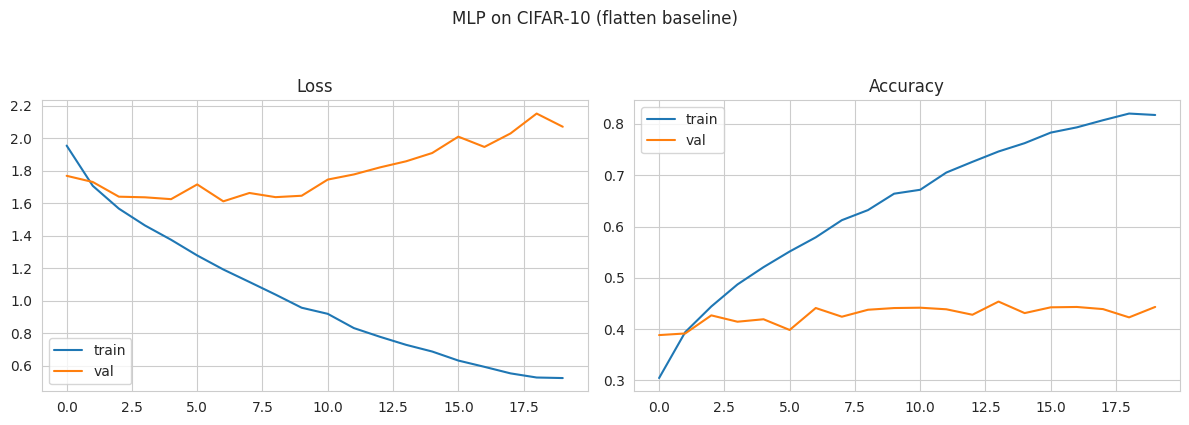

In [13]:
mlp = CIFARMLP().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=cfg.lr)

history_mlp = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, cfg.epochs + 1):
    tr_loss, tr_acc = train_one_epoch(mlp, train_loader, optimizer, criterion)
    va_loss, va_acc = evaluate(mlp, val_loader, criterion)

    history_mlp['train_loss'].append(tr_loss)
    history_mlp['val_loss'].append(va_loss)
    history_mlp['train_acc'].append(tr_acc)
    history_mlp['val_acc'].append(va_acc)

    print(f"Epoch {epoch:02d}/{cfg.epochs} | train loss {tr_loss:.3f} acc {tr_acc:.3f} | val loss {va_loss:.3f} acc {va_acc:.3f}")

plot_curves(history_mlp, title='MLP on CIFAR-10 (flatten baseline)')


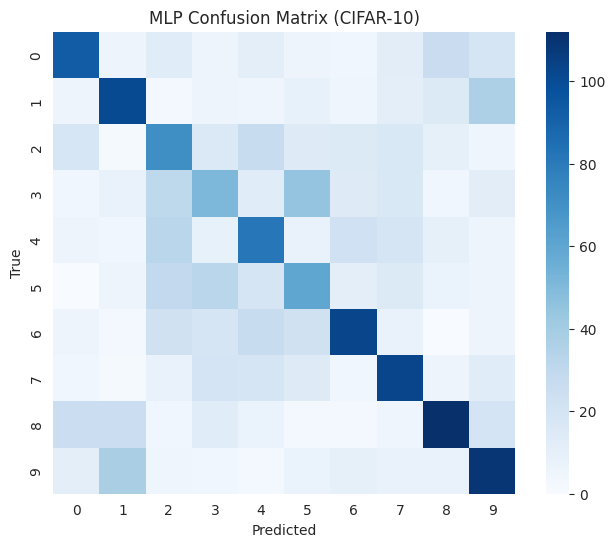

              precision    recall  f1-score   support

    airplane       0.54      0.47      0.50       196
  automobile       0.52      0.51      0.51       198
        bird       0.33      0.36      0.34       195
         cat       0.29      0.26      0.27       199
        deer       0.38      0.41      0.40       198
         dog       0.32      0.32      0.32       185
        frog       0.54      0.48      0.50       216
       horse       0.48      0.53      0.50       193
        ship       0.57      0.52      0.54       217
       truck       0.47      0.54      0.50       203

    accuracy                           0.44      2000
   macro avg       0.44      0.44      0.44      2000
weighted avg       0.44      0.44      0.44      2000



In [14]:
@torch.no_grad()
def predict_all(model: nn.Module, loader: DataLoader) -> tuple[np.ndarray, np.ndarray]:
    model.eval()
    ys = []
    preds = []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        p = logits.argmax(dim=1).cpu().numpy()
        preds.append(p)
        ys.append(y.numpy())
    return np.concatenate(ys), np.concatenate(preds)

y_true_mlp, y_pred_mlp = predict_all(mlp, test_loader)
cm = confusion_matrix(y_true_mlp, y_pred_mlp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap='Blues', square=True)
plt.title('MLP Confusion Matrix (CIFAR-10)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true_mlp, y_pred_mlp, target_names=classes))

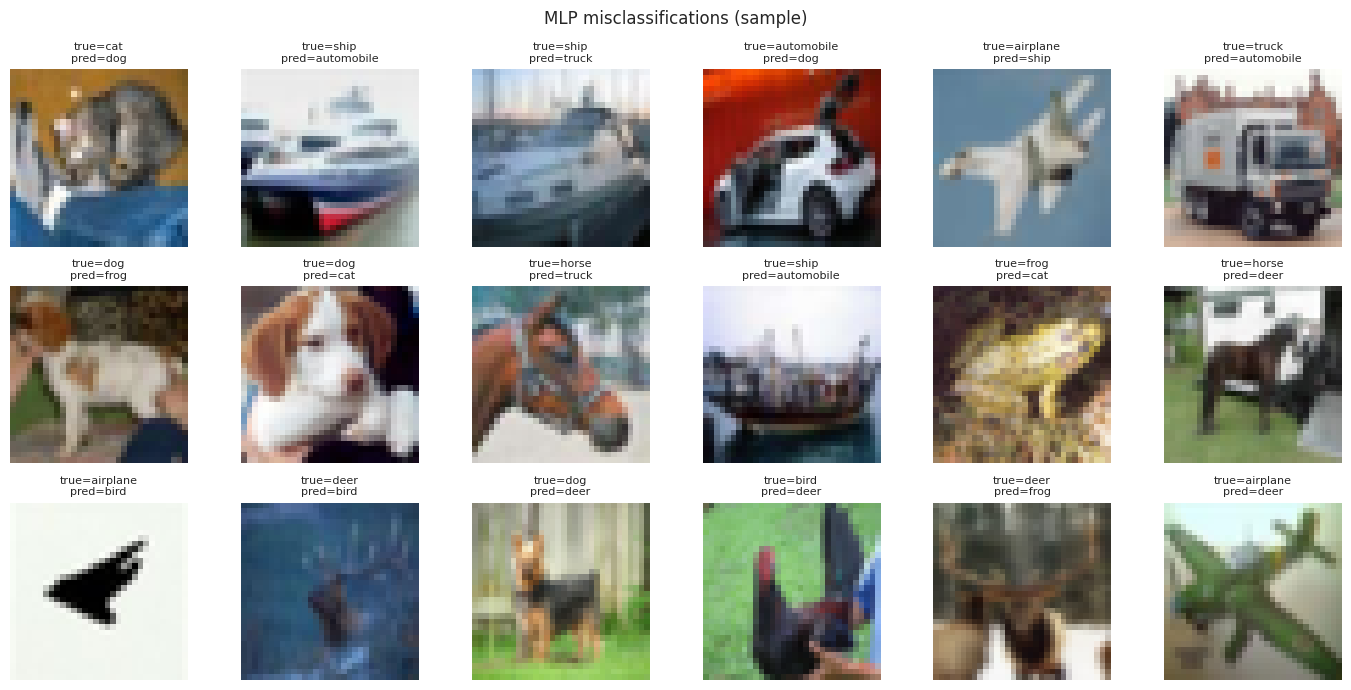

In [15]:
# Visualize some MLP mistakes
wrong = np.where(y_true_mlp != y_pred_mlp)[0]
n_show = min(18, len(wrong))

fig, axes = plt.subplots(3, 6, figsize=(14, 7))
axes = axes.reshape(-1)

# We want to display images in original (non-normalized) space for readability
display_ds = datasets.CIFAR10(root=str(DATA_DIR), train=False, download=True, transform=transform_raw)

for i in range(n_show):
    idx = int(wrong[i])
    x_img, _ = display_ds[idx]
    ax = axes[i]
    ax.imshow(x_img.permute(1, 2, 0))
    ax.set_title(
        f"true={classes[y_true_mlp[idx]]}\npred={classes[y_pred_mlp[idx]]}",
        fontsize=8,
    )
    ax.axis('off')

for ax in axes[n_show:]:
    ax.axis('off')

plt.suptitle('MLP misclassifications (sample)')
plt.tight_layout()
plt.show()


## 5. Practical: CIFAR-10 with a Small CNN
Now we switch to a CNN that preserves the 2D structure.

Even a small CNN tends to outperform an MLP on CIFAR-10 because it can learn reusable local features (edges, corners, textures) and compose them into higher-level patterns.

In [16]:
class CIFARCNN(nn.Module):
    def __init__(self, dropout: float = 0.25):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Dropout(dropout),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8
            nn.Dropout(dropout),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # (128,1,1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        return self.classifier(x)

# CNN one step
cnn_smoke = CIFARCNN().to(device)
opt_cnn = optim.Adam(cnn_smoke.parameters(), lr=cfg.lr)
logits = cnn_smoke(x_batch)
loss = criterion(logits, y_batch)
loss.backward()
opt_cnn.step()
print('CNN smoke step ok | loss:', float(loss.item()))

CNN smoke step ok | loss: 2.295891284942627


Epoch 01/20 | train loss 2.163 acc 0.179 | val loss 2.104 acc 0.209
Epoch 02/20 | train loss 2.000 acc 0.232 | val loss 2.003 acc 0.240
Epoch 03/20 | train loss 1.855 acc 0.291 | val loss 1.802 acc 0.339
Epoch 04/20 | train loss 1.795 acc 0.323 | val loss 1.760 acc 0.353
Epoch 05/20 | train loss 1.734 acc 0.343 | val loss 1.698 acc 0.348
Epoch 06/20 | train loss 1.657 acc 0.380 | val loss 1.633 acc 0.389
Epoch 07/20 | train loss 1.591 acc 0.410 | val loss 1.615 acc 0.400
Epoch 08/20 | train loss 1.577 acc 0.423 | val loss 1.574 acc 0.428
Epoch 09/20 | train loss 1.516 acc 0.446 | val loss 1.514 acc 0.444
Epoch 10/20 | train loss 1.492 acc 0.444 | val loss 1.516 acc 0.462
Epoch 11/20 | train loss 1.448 acc 0.474 | val loss 1.534 acc 0.447
Epoch 12/20 | train loss 1.429 acc 0.478 | val loss 1.444 acc 0.486
Epoch 13/20 | train loss 1.370 acc 0.501 | val loss 1.519 acc 0.455
Epoch 14/20 | train loss 1.348 acc 0.515 | val loss 1.407 acc 0.500
Epoch 15/20 | train loss 1.350 acc 0.512 | val l

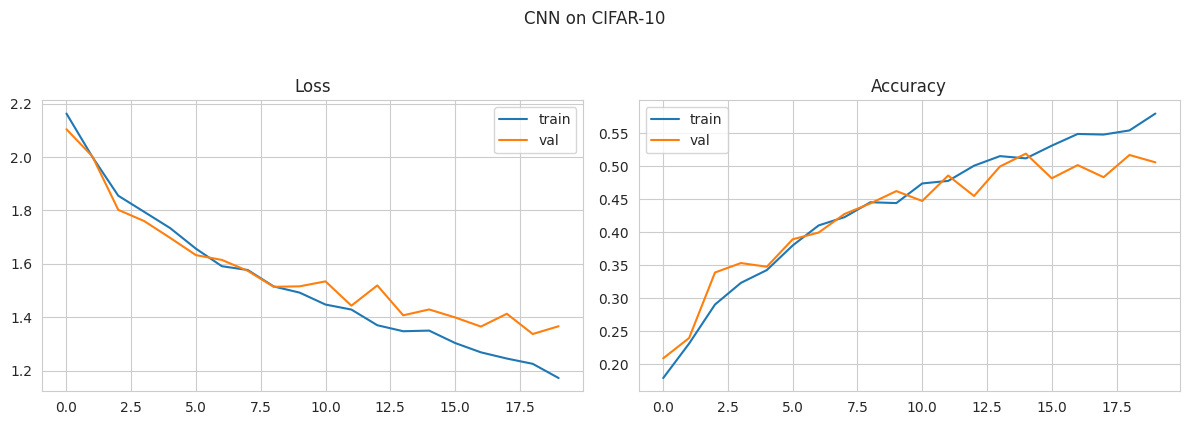

In [17]:
cnn = CIFARCNN().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=cfg.lr)

history_cnn = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, cfg.epochs + 1):
    tr_loss, tr_acc = train_one_epoch(cnn, train_loader, optimizer, criterion)
    va_loss, va_acc = evaluate(cnn, val_loader, criterion)

    history_cnn['train_loss'].append(tr_loss)
    history_cnn['val_loss'].append(va_loss)
    history_cnn['train_acc'].append(tr_acc)
    history_cnn['val_acc'].append(va_acc)

    print(f"Epoch {epoch:02d}/{cfg.epochs} | train loss {tr_loss:.3f} acc {tr_acc:.3f} | val loss {va_loss:.3f} acc {va_acc:.3f}")

plot_curves(history_cnn, title='CNN on CIFAR-10')


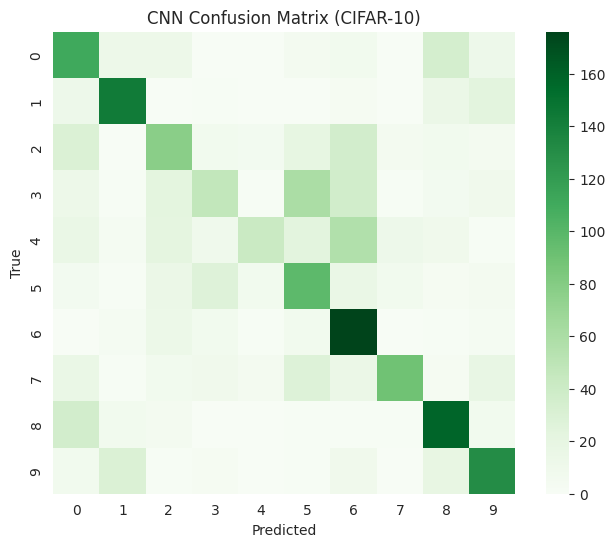

              precision    recall  f1-score   support

    airplane       0.45      0.57      0.50       196
  automobile       0.70      0.72      0.71       198
        bird       0.43      0.39      0.41       195
         cat       0.42      0.24      0.30       199
        deer       0.67      0.21      0.32       198
         dog       0.40      0.53      0.46       185
        frog       0.49      0.81      0.61       216
       horse       0.77      0.47      0.58       193
        ship       0.61      0.73      0.67       217
       truck       0.60      0.65      0.62       203

    accuracy                           0.54      2000
   macro avg       0.55      0.53      0.52      2000
weighted avg       0.56      0.54      0.52      2000



In [18]:
y_true_cnn, y_pred_cnn = predict_all(cnn, test_loader)
cm = confusion_matrix(y_true_cnn, y_pred_cnn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap='Greens', square=True)
plt.title('CNN Confusion Matrix (CIFAR-10)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true_cnn, y_pred_cnn, target_names=classes))

### Compare MLP vs CNN
We’ll compare a few key numbers and overlay the learning curves.

MLP test accuracy: 0.442
CNN test accuracy: 0.536


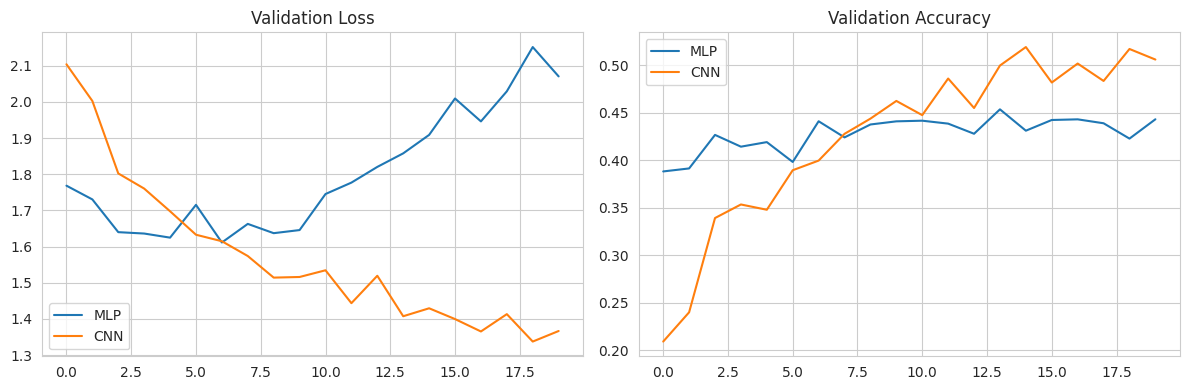

In [19]:
mlp_acc = (y_true_mlp == y_pred_mlp).mean()
cnn_acc = (y_true_cnn == y_pred_cnn).mean()

print(f"MLP test accuracy: {mlp_acc:.3f}")
print(f"CNN test accuracy: {cnn_acc:.3f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mlp['val_loss'], label='MLP')
plt.plot(history_cnn['val_loss'], label='CNN')
plt.title('Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mlp['val_acc'], label='MLP')
plt.plot(history_cnn['val_acc'], label='CNN')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### What did the CNN learn? (A quick peek)
We can visualize the **first-layer filters** and a few **feature maps**.
These aren’t perfect explanations, but they help build intuition that CNNs learn reusable local patterns.

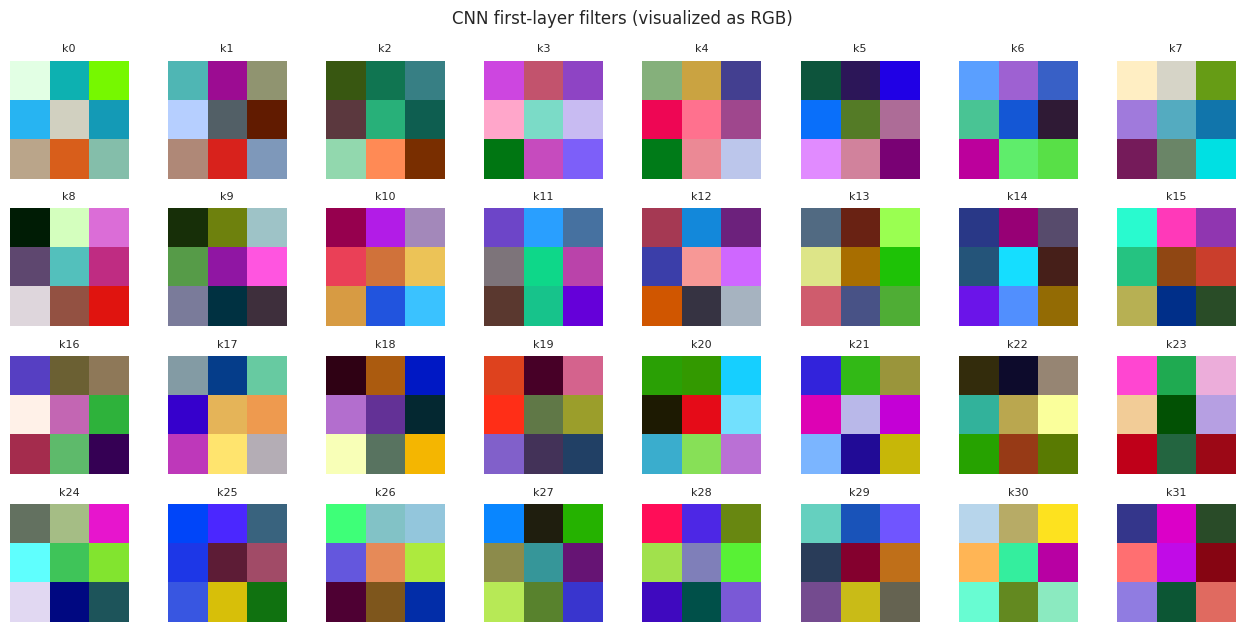

In [20]:
# Visualize first conv filters
first_conv: nn.Conv2d | None = None
for m in cnn.modules():
    if isinstance(m, nn.Conv2d):
        first_conv = m
        break

assert first_conv is not None

w = first_conv.weight.detach().cpu()  # (out_channels, in_channels, k, k)
out_ch = min(32, w.shape[0])
cols = 8
rows = int(math.ceil(out_ch / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.6, rows * 1.6))
axes = np.array(axes).reshape(-1)

for i in range(out_ch):
    # Normalize filter to [0,1] for display
    filt = w[i]
    filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)
    axes[i].imshow(filt.permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f"k{i}", fontsize=8)

for ax in axes[out_ch:]:
    ax.axis('off')

plt.suptitle('CNN first-layer filters (visualized as RGB)')
plt.tight_layout()
plt.show()


Found 5 conv layers


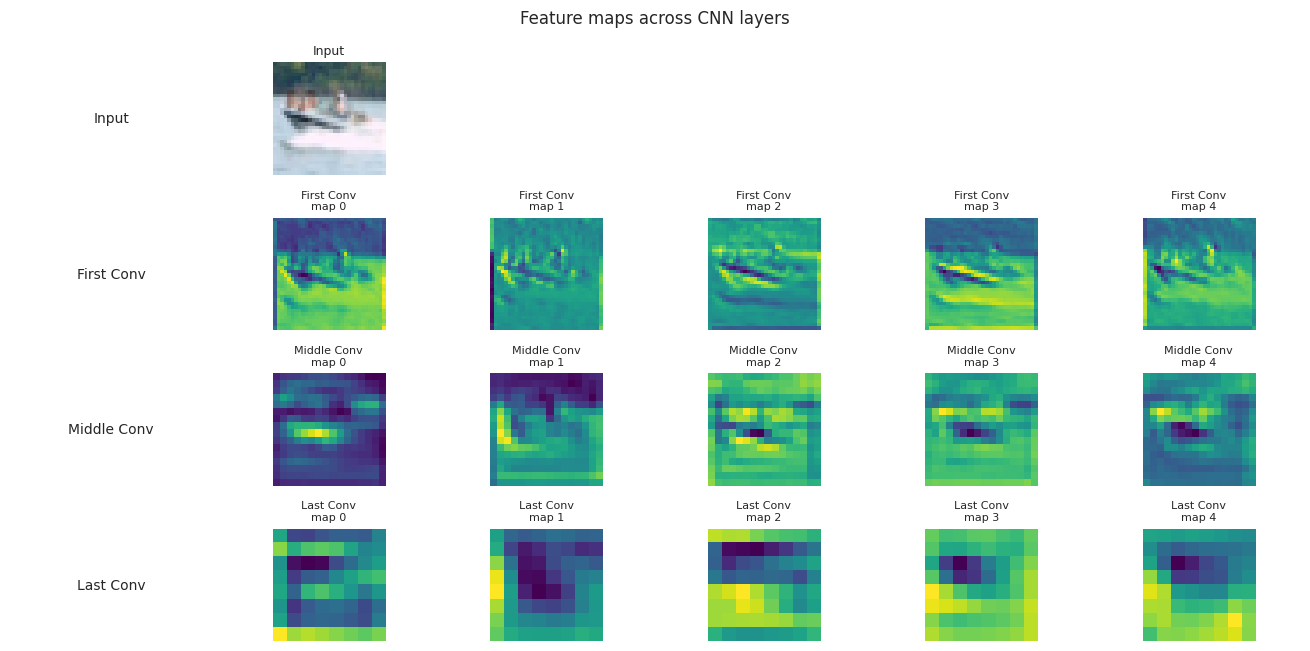

In [34]:
# Visualize feature maps from multiple conv layers for one image
cnn.eval()

# Pick a random index and use it consistently
vis_idx = np.random.randint(len(full_test))
x_vis, _ = full_test[vis_idx]
x_vis = x_vis.unsqueeze(0).to(device)

# Get the same image from test_raw for display
x_display, _ = test_raw[vis_idx]

# Extract conv layers
conv_layers = [m for m in cnn.features.modules() if isinstance(m, nn.Conv2d)]
print(f"Found {len(conv_layers)} conv layers")

# Select first, middle, and last conv layers
layer_indices = [0, len(conv_layers) // 2, len(conv_layers) - 1]
selected_layers = [conv_layers[i] for i in layer_indices]
layer_names = ['First Conv', 'Middle Conv', 'Last Conv']

n_maps = 5
fig, axes = plt.subplots(1+len(selected_layers), n_maps + 1, figsize=((n_maps + 1) * 2.2, len(selected_layers) * 2.2))

# Forward through layers progressively
x_curr = x_vis
layer_idx = 0

axes[0, 1].imshow(x_display.permute(1, 2, 0))
axes[0, 1].set_title('Input', fontsize=9)
axes[0, 0].text(0.5, 0.5, "Input", ha='center', va='center', fontsize=10, transform=axes[0, 0].transAxes)
for i in range(0, n_maps + 1): axes[0, i].axis('off')

for row_idx, (layer, name) in enumerate(zip(selected_layers, layer_names)):
    row_idx += 1
    # Forward until we reach this layer
    while layer_idx < len(cnn.features):
        module = cnn.features[layer_idx]
        x_curr = module(x_curr)
        if module is layer:
            break
        layer_idx += 1
    
    layer_idx += 1
    
    # Get feature maps after this conv layer
    fm = x_curr.detach().cpu().squeeze(0)  # (C,H,W)
    
    # Show original image in first column (only in first row)
    axes[row_idx, 0].text(0.5, 0.5, name, ha='center', va='center', fontsize=10, transform=axes[row_idx, 0].transAxes)
    axes[row_idx, 0].axis('off')
    
    # Show feature maps
    for i in range(n_maps):
        if i < fm.shape[0]:
            m = fm[i]
            m = (m - m.min()) / (m.max() - m.min() + 1e-8)
            axes[row_idx, i + 1].imshow(m, cmap='viridis')
            axes[row_idx, i + 1].set_title(f"{name}\nmap {i}", fontsize=8)
        axes[row_idx, i + 1].axis('off')

plt.suptitle('Feature maps across CNN layers')
plt.tight_layout()
plt.show()


## 6. Summary
- Images are **structured tensors** (signals) with strong local correlations.
- CV includes many task types (classification, detection, segmentation, generation).
- MLPs can learn from images but flattening often loses critical spatial structure.
- CNNs encode a helpful inductive bias: **locality + weight sharing + feature hierarchies**.

### Suggested exercises
1. Increase `epochs` and set `QUICK_RUN = False` → compare final metrics.
2. Add basic augmentation (random crop/flip) → measure generalization.
3. Inspect which classes are most confused and propose why.
4. Investigate pretrained CNN models (e.g. ResNet) and try finetuning them for our CIFAR10 classification task.

---
Next: we’ll revisit vision with a different paradigm (Transformers), but only after we’re solid on CNN fundamentals.